In [21]:
import pandas as pd
import sqlite3
import datetime
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from ipywidgets import FloatProgress

## Connect to DB, load data and convert to dataframe

In [2]:
db_path = "data/twitter_data.db"

In [3]:
conn = sqlite3.connect(db_path)
c = conn.cursor()

In [4]:
c.execute('SELECT SQLITE_VERSION()')

In [5]:
c.execute('SELECT * FROM tweets')
raw_data = c.fetchall()

In [6]:
conn.close()

In [7]:
raw_df = pd.DataFrame(raw_data)
raw_df.columns = ['text', 'username', 'date', 'location']

### Clean Twitter data

In [8]:
raw_df['date'] = pd.to_datetime(raw_df['date'])

In [9]:
import re

def tweet_cleaner(s):    
    s = re.sub(r"http\S+", "", s)
    s = s.replace("’", "'")
    #s = s.replace("'", "")
    s = s.replace("amp", "")
    #s = re.sub(r"\s*[^A-Za-z]+\s*", " ", s)
    #s = s.lower()
    return s

testing = raw_df.text[:]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))

In [10]:
# Combine into dataframe
test = pd.DataFrame(test_result)
test.columns = ['text']
clean_df = pd.concat([test, raw_df['date'], raw_df['location']], axis=1)
clean_df = clean_df[clean_df.text.str.contains('lebron')]
clean_df = clean_df.reset_index(drop=True)

In [11]:
clean_df[:10]

,text,date,location
0,@31TyRichh If bron didn't sign I think we woul...,2018-07-04 05:09:20,
1,@BruhReport @WIllEdwards_53 What if I told you...,2018-07-04 05:08:54,
2,Magic Johnson's roster acquisitions outside of...,2018-07-04 05:08:39,"San Antonio, TX"
3,Bam next lebron\nDJJ next KD\n\nBoth on the he...,2018-07-04 05:08:23,NY
4,so me &; this guy arguing on snapchat about th...,2018-07-04 05:08:14,601
5,@brkicks @T_Jones717 rocking the lebron 15 lows,2018-07-04 05:08:08,
6,-bryant to come out of retirement and beat the...,2018-07-04 05:07:37,viiiiviixvi
7,Just do it. #ChangeTheBanner #cleveland #lebron,2018-07-04 05:07:14,"Chicago, IL"
8,@MSN @boogiecousins But got lebron instead,2018-07-04 05:06:56,"Chicago, IL"
9,2 days and I still have yet to figure out why ...,2018-07-04 05:06:47,"San Luis Obispo, CA"


### Date Time Period

In [12]:
# time of tweet #edate = datetime.datetime(2018, 7, 2, 0, 0)

main_tdate = datetime.datetime(2018, 7, 2, 0, 0)
sdate = datetime.datetime(2018,7,1,0,0,0)
edate = datetime.datetime(2018,7,3,0,0,0)
date_df = []
date_df.append(sdate)

date = sdate
while date < edate:
    date += datetime.timedelta(minutes=1)
    date_df.append(date)

### Tweets per minute

In [13]:
tweet_count = []
tweet_date = []
for i in range(0,len(date_df)-1):
    mask = (clean_df['date'] <= date_df[i+1]) & (clean_df['date'] > date_df[i])
    tweet_count.append(len(clean_df.loc[mask]))
    tweet_date.append(date_df[i])
tweet_count.append(0)

In [14]:
x = range(0,len(tweet_count))
xtickrange=np.arange(min(x), max(x), 500)
dtick=['']
for pos,tick in enumerate(xtickrange):
    dtick.append(str(tweet_date[tick]))
dtick.append(str((tweet_date[500]-tweet_date[0])+tweet_date[tick]))

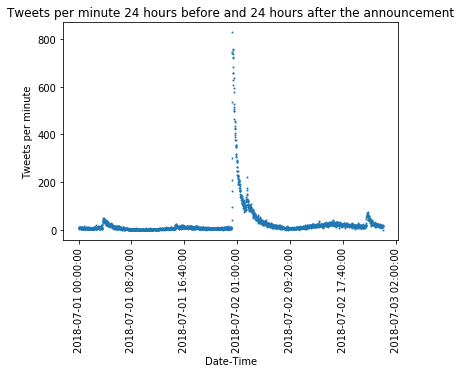

In [15]:
fig, ax = plt.subplots()
fig.canvas.draw()
plt.scatter(x, tweet_count,s=1)
ax.set_xticklabels(dtick)
plt.xticks(rotation=90)
ax.set_xlabel('Date-Time')
ax.set_ylabel('Tweets per minute')
plt.title('Tweets per minute 24 hours before and 24 hours after the announcement')
plt.show()

The scatter graph above presents the number of tweets published per minute that mention 'LeBron'. The data **excludes** retweets and favourites, only tweets explicitly written by users are considered. The date range of the graph is 24 hours before and 24 hours after the annoucement of LeBron's free-agent status. The rate of Tweets per minute (TPM) clearly spikes to a maximum of 829TPM around the time the announcement was made.

### Get data within window of interest

In [16]:
mask = (clean_df['date'] > sdate) & (clean_df['date'] <= edate)
sub_df = clean_df.loc[mask]
sub_df=sub_df.reset_index(drop=True)

### Word cloud

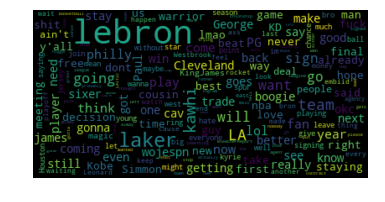

In [17]:
mask = (sub_df['date'] > sdate) & (sub_df['date'] <= main_tdate)
temp = sub_df.loc[mask]
single_text=temp['text'].str.cat(sep=', ')
wordcloud = WordCloud(collocations=False,max_font_size=40).generate(single_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

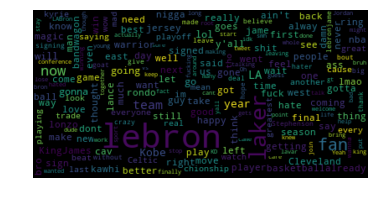

In [18]:
mask = (sub_df['date'] > main_tdate) & (sub_df['date'] <= edate)
temp = sub_df.loc[mask]
single_text=temp['text'].str.cat(sep=', ')
wordcloud = WordCloud(collocations=False,max_font_size=40).generate(single_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Sentiment Analysis

In [19]:
sid = SentimentIntensityAnalyzer()

In [22]:
sentdata = pd.DataFrame(columns=['neg', 'neu', 'pos', 'compound'])
        
test = sub_df.text[:]
max_count = len(test)
f = FloatProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

for idxc, sentence in enumerate(test):
    f.value += 1
    ss = sid.polarity_scores(sentence)
    sentdata = sentdata.append(pd.DataFrame(ss, index=[0]))
sentdata = sentdata.reset_index(drop=True)
sentdata=sentdata.reindex(index=sentdata.index[::-1])

FloatProgress(value=0.0, max=78153.0)

/Users/Luqman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


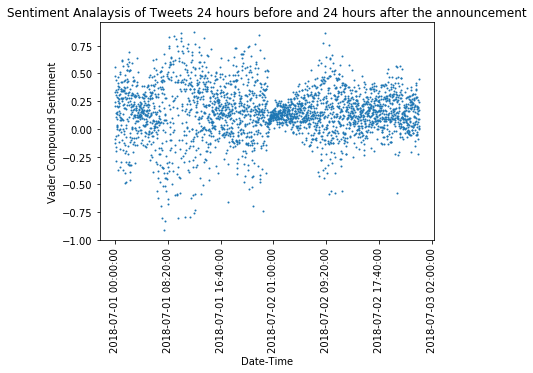

In [23]:
date_df = []
date_df.append(sdate)
date = sdate
while date < edate:
    date += datetime.timedelta(minutes=1)
    date_df.append(date)

tweet_sent=[]
for i in range(0,len(date_df)-1):
    mask = (sub_df['date'] <= date_df[i+1]) & (sub_df['date'] > date_df[i])
    temp=sentdata.loc[mask]['compound'].copy()
    temp[temp == 0] = np.nan
    res = np.nanmean(temp)
    tweet_sent.append(res)
    
fig, ax = plt.subplots()
fig.canvas.draw()
x = range(0,len(tweet_sent))
plt.scatter(x, tweet_sent,s=1)
ax.set_xticklabels(dtick)
plt.xticks(rotation=90)
ax.set_xlabel('Date-Time')
ax.set_ylabel('Vader Compound Sentiment')
plt.title('Sentiment Analaysis of Tweets 24 hours before and 24 hours after the announcement')
plt.show()

In [ ]:
# date_df = []
# date_df.append(sdate)
# date = sdate
# while date < edate:
#     date += datetime.timedelta(seconds=30)
#     date_df.append(date)

# tweet_sent=[]
# for i in range(0,len(date_df)-1):
#     mask = (sub_df['date'] <= date_df[i+1]) & (sub_df['date'] > date_df[i])
#     temp=sentdata.loc[mask]['compound'].copy()
#     temp[temp == 0] = np.nan
#     res = np.nanmean(temp)
#     tweet_sent.append(res)
    
# fig, ax = plt.subplots()
# fig.canvas.draw()
# x = range(0,len(tweet_sent))
# plt.scatter(x, tweet_sent,s=1)
# ax.set_xticklabels(dtick)
# plt.xticks(rotation=90)
# ax.set_xlabel('Date-Time')
# ax.set_ylabel('Vader Compound Sentiment')
# plt.title('Sentiment Analaysis of Tweets 24 hours before and 24 hours after the announcement')
# plt.show()

### Sentiment before announcement

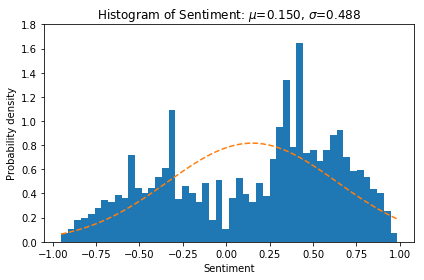

In [51]:
mask = (sub_df['date'] < main_tdate) & (sub_df['date'] >= sdate)
temp=sentdata.loc[mask]['compound'].copy()
tweetnonan = [x for x in temp if str(x) != 'nan']
tweetnonan = [x for x in tweetnonan if x != 0]
b4=tweetnonan
fig, ax = plt.subplots()
n, bins, patches = ax.hist(tweetnonan, bins=50, density=1)

mu=np.mean(tweetnonan, axis=0)
sigma=np.std(tweetnonan, axis=0)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of Sentiment: $\mu$=%.3f, $\sigma$=%.3f' % (mu,sigma))
ax.set_ylim([0,1.8])

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

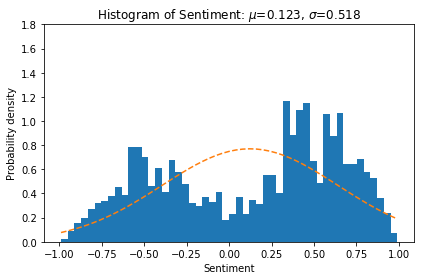

In [52]:
mask = (sub_df['date'] < edate) & (sub_df['date'] >= main_tdate)
temp=sentdata.loc[mask]['compound'].copy()
tweetnonan = [x for x in temp if str(x) != 'nan']
tweetnonan = [x for x in tweetnonan if x != 0]
b5=tweetnonan
fig, ax = plt.subplots()
n, bins, patches = ax.hist(tweetnonan, bins=50, density=1)

mu=np.mean(tweetnonan, axis=0)
sigma=np.std(tweetnonan, axis=0)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Probability density')
ax.set_ylim([0,1.8])
ax.set_title(r'Histogram of Sentiment: $\mu$=%.3f, $\sigma$=%.3f' % (mu,sigma))

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

In [54]:
len(b4)

7470

In [55]:
len(b5)

48272

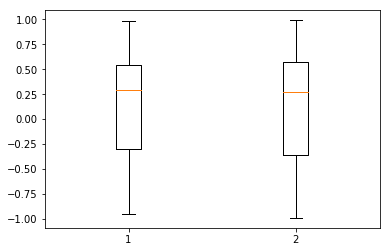

In [53]:
data_to_plot = [b4, b5]
fig, ax = plt.subplots()
ax.boxplot(data_to_plot)
plt.show()

### Wordcloud of Sentiment Data

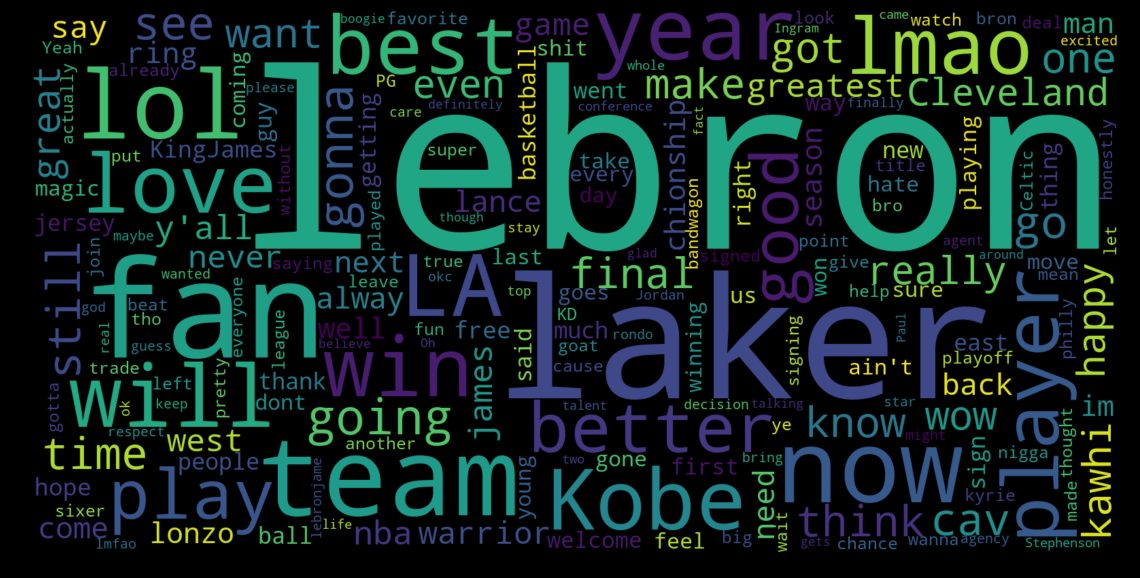

In [56]:
mask = (sentdata['compound'] > 0.5)
temp=sub_df.loc[mask]['text'].copy()
single_text=temp.str.cat(sep=', ')
wordcloud = WordCloud(collocations=False,width=1600, height=800,random_state=42).generate(single_text)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('goodcloud.png', facecolor='k', bbox_inches='tight')
plt.show()

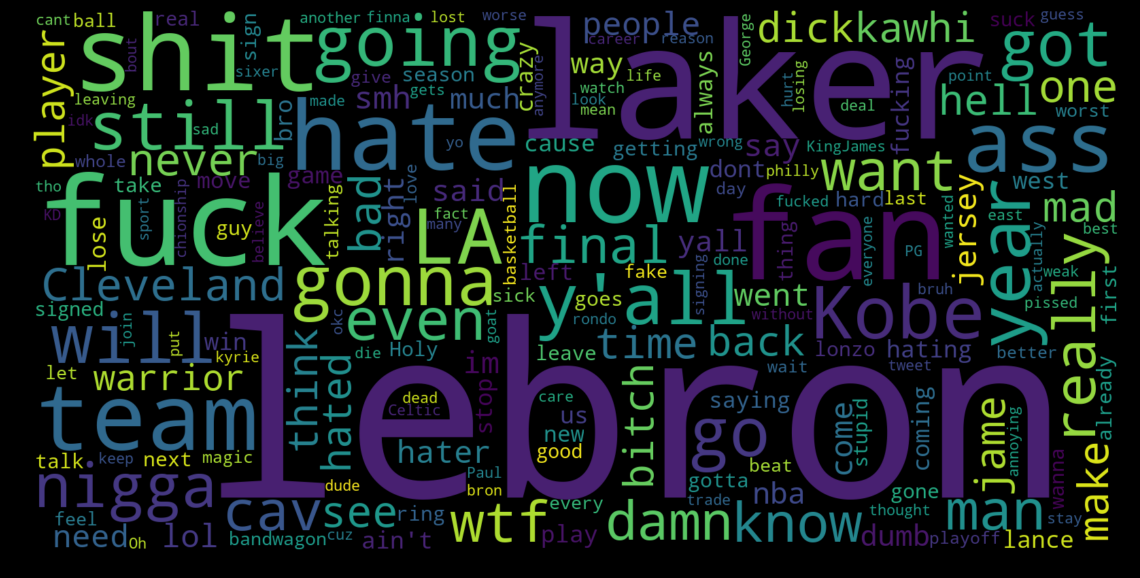

In [57]:
mask = (sentdata['compound'] < -0.5)
temp=sub_df.loc[mask]['text'].copy()
single_text=temp.str.cat(sep=', ')
wordcloud = WordCloud(collocations=False,width=1600, height=800,random_state=42).generate(single_text)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('badcloud.png', facecolor='k', bbox_inches='tight')
plt.show()